<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [10]:
df=pd.read_csv('Train_cleaned.csv')

In [11]:
target_col='cluster_category'
y=df[target_col]
X=df.drop(columns=[target_col])

In [15]:
X.columns

Index(['Customer_ID', 'outlet_city', 'luxury_sales', 'fresh_sales',
       'dry_sales', 'Area'],
      dtype='object')

In [12]:
# (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [20]:
from sklearn import preprocessing
#Initiating the label encoder
label_encoder = preprocessing.LabelEncoder()
#Encoding the variables for easier analysis
columns_to_encode = ['Customer_ID', 'outlet_city', 'luxury_sales', 'fresh_sales', 'dry_sales', 'Area']

# Loop through each column and apply label encoding
# Apply encoding to the entire DataFrame before splitting
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

# Now split the encoded DataFrame
target_col='cluster_category'
y=df[target_col]
X=df.drop(columns=[target_col])

# (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Train Random Forest Classifier with the now encoded data
rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE

# SMOTE resampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Very constrained hyperparameter space to reduce complexity
param_dist = {
    'n_estimators': [10, 20, 30],
    'max_depth': [2, 3, 4],
    'min_samples_split': [150, 200],
    'min_samples_leaf': [50, 100],
    'max_features': ['sqrt'],
    'ccp_alpha': [0.1, 0.2, 0.3]
}

# StratifiedKFold to preserve class ratios
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV with aggressive regularization and fast runtime
rf_rscv = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=3,                           # Limited to 3 combinations for speed
    cv=cv_strategy,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit model
rf_rscv.fit(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.1, 0.2, 0.3],
                                        'max_depth': [2, 3, 4],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [50, 100],
                                        'min_samples_split': [150, 200],
                                        'n_estimators': [10, 20, 30]},
                   scoring='balanced_accuracy', verbose=1)

In [61]:
rf_rscv.fit(X_train, y_train)
print("Best Parameters:", rf_rscv.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'n_estimators': 20, 'min_samples_split': 150, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 4, 'ccp_alpha': 0.1}


In [62]:
best_model= rf_rscv.best_estimator_
y_pred_rf = best_model.predict(X_test)

In [63]:
from sklearn.metrics import accuracy_score
accuracy_best = accuracy_score(y_test, y_pred_rf)
print(f"Best Model Accuracy: {accuracy_best * 100:.2f}%")

Best Model Accuracy: 95.94%


In [64]:
# Classification model after optimizing
y_pred_rf = best_model.predict(X_test)
print("Optimized Classification Report:\n", classification_report(y_test, y_pred_rf))

Optimized Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.99      0.99     56694
         2.0       0.91      1.00      0.95     46519
         3.0       0.94      0.74      0.82     14672
         4.0       1.00      1.00      1.00     51732
         5.0       0.98      0.61      0.75     11862
         6.0       0.93      0.99      0.96     50765

    accuracy                           0.96    232244
   macro avg       0.96      0.89      0.91    232244
weighted avg       0.96      0.96      0.96    232244



In [65]:
rf_best = rf_rscv.best_estimator_

In [66]:
print(rf_rscv.best_params_)

{'n_estimators': 20, 'min_samples_split': 150, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 4, 'ccp_alpha': 0.1}


In [67]:
#prediction on the test data
y_pred_rf = rf_best.predict(X_test)

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix for RF


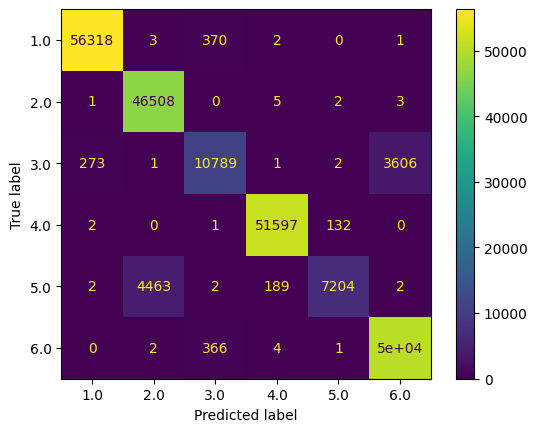

In [69]:
print("confusion_matrix for RF")
rf_cm=confusion_matrix(y_test,y_pred_rf)
disp=ConfusionMatrixDisplay(confusion_matrix=rf_cm,display_labels = rf_best.classes_)
disp.plot()

In [70]:
from sklearn.model_selection import learning_curve
# learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

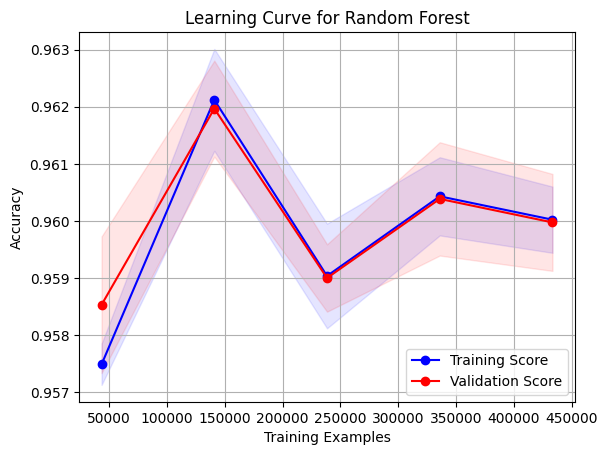

In [71]:
# Plot training accuracy
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
# Plot validation accuracy
plt.plot(train_sizes, test_mean, 'o-', color="red", label="Validation Score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="red")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [72]:
from sklearn.metrics import accuracy_score

# Train Accuracy
train_accuracy = accuracy_score(y_train, rf_best.predict(X_train))
print(f"Train Accuracy: {train_accuracy:.4f}")

# Test Accuracy
test_accuracy = accuracy_score(y_test, rf_best.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Accuracy: 0.9595
Test Accuracy: 0.9594


In [73]:
# Feature Importance
importances = rf_best.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:\n", feature_importance_df)

Feature Importance:
         Feature  Importance
5          Area    0.324165
4     dry_sales    0.251935
3   fresh_sales    0.217629
2  luxury_sales    0.206271
1   outlet_city    0.000000
0   Customer_ID    0.000000


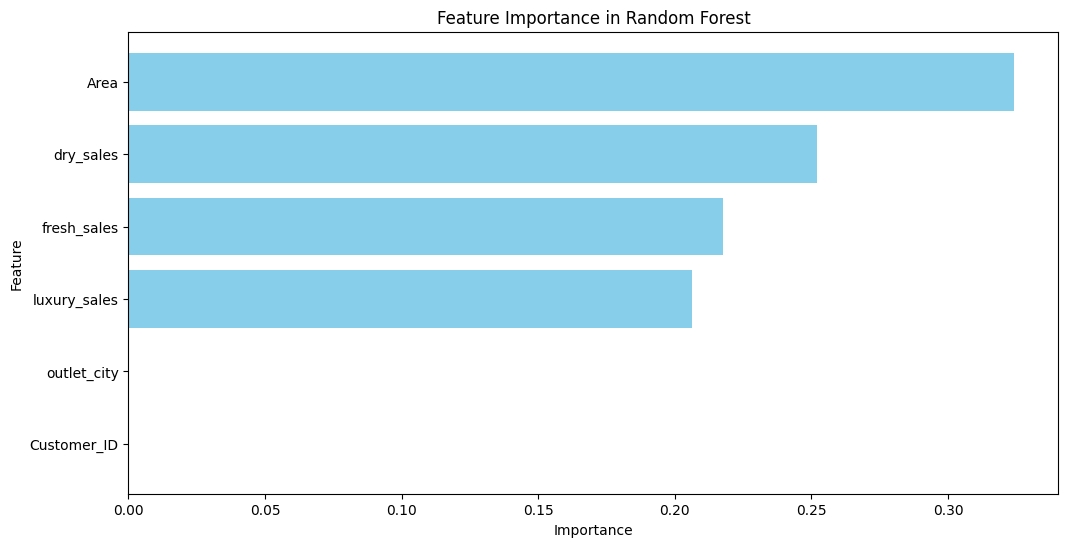

In [74]:
# Feature Importance Plot
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

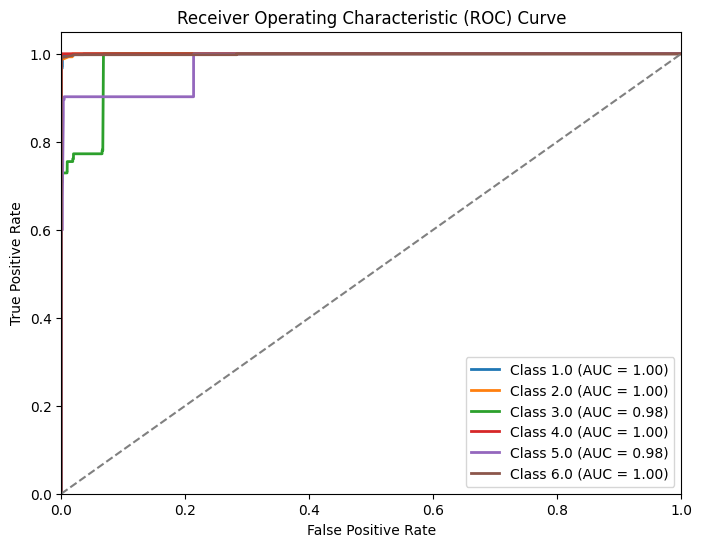

In [75]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the target variable for multiclass ROC
y_test_bin = label_binarize(y_test, classes=rf_rscv.classes_)
y_pred_prob = rf_rscv.best_estimator_.predict_proba(X_test)

# Calculate and plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {rf_rscv.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot chance level (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [76]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})
print(comparison_df.head(10))

        Actual  Predicted
315088     2.0        2.0
181368     2.0        2.0
202239     2.0        2.0
328564     5.0        2.0
620964     6.0        6.0
444746     1.0        1.0
247935     2.0        2.0
620636     6.0        6.0
225925     2.0        2.0
119252     4.0        4.0
